# Part 3 - K-Fold Cross-Validation BioClinical BERT Classifier for Medical Specialist Prediction
## Optimized for Google Colab

This notebook implements a robust K-Fold Cross-Validation BioClinical BERT-based classifier to predict the appropriate medical specialist from referral letters. Optimized for Google Colab with GPU/TPU acceleration.

## Key Google Colab Optimizations
- **GPU/TPU acceleration** for faster training
- **Colab-specific installations** and configurations
- **Memory optimization** for Colab's resource limits
- **File handling** for Colab environment
- **Progress tracking** with Colab-friendly visualizations

## Table of Contents

1. [Colab Setup and GPU Configuration](#1-colab-setup-and-gpu-configuration)
2. [Data Upload and Loading](#2-data-upload-and-loading)
3. [Data Exploration and Preprocessing](#3-data-exploration-and-preprocessing)
4. [K-Fold Cross-Validation Configuration](#4-k-fold-cross-validation-configuration)
5. [BioClinical BERT Model Architecture](#5-bioclinical-bert-model-architecture)
6. [K-Fold Cross-Validation Training](#6-k-fold-cross-validation-training)
7. [Results Analysis and Download](#7-results-analysis-and-download)

## 1. Colab Setup and GPU Configuration

**Important:** Go to Runtime → Change runtime type → Hardware accelerator → GPU (T4, V100, or A100 if available)

This section sets up the Google Colab environment with GPU acceleration and installs required packages.

In [7]:
# Check GPU availability and setup
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("WARNING: GPU not available. Please enable GPU in Runtime → Change runtime type")

!pip install transformers==4.21.0 -q
!pip install datasets -q
!pip install accelerate -q
!pip install scikit-learn -q
!pip install seaborn -q

print("All packages installed successfully!")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU device: Tesla T4
GPU memory: 14.7 GB
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (tokenizers)
All packages installed successfully!

Using device: cuda


In [ ]:
# All imports consolidated at the top
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    BertTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import warnings
import re
from tqdm.auto import tqdm
import json
import time
import gc
import os
import glob
import shutil
from datetime import datetime

# Safe Google Colab imports
try:
    from google.colab import files
    colab_available = True
except ImportError:
    colab_available = False

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

CONFIG = {
    'MODEL_NAME': 'emilyalsentzer/Bio_ClinicalBERT',
    'MAX_LENGTH': 384,
    'BATCH_SIZE': 3,
    'ACCUMULATION_STEPS': 12,
    'LEARNING_RATE': 2e-5,
    'EPOCHS_PER_FOLD': 15,
    'K_FOLDS': 5,
    'WARMUP_RATIO': 0.08,
    'WEIGHT_DECAY': 0.02,
    'DROPOUT': 0.2,
    'GRADIENT_CLIP': 1.0,
    'PATIENCE': 7,
    'MIN_SAMPLES_PER_CLASS': 30,
    'FOCAL_LOSS_ALPHA': 0.3,
    'FOCAL_LOSS_GAMMA': 2.5,
    'USE_WEIGHTED_SAMPLING': True,
    'LABEL_SMOOTHING': 0.05,
    'USE_MIXED_PRECISION': True,
    'MIN_LR': 5e-8,
    'USE_GRADUAL_UNFREEZING': True,
    'SAVE_CHECKPOINTS': True,
    'AUGMENTATION_PROB': 0.4
}

print("Configuration for BioClinical BERT Training:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print(f"\nTraining parameters:")
print(f"  + Epochs per fold: {CONFIG['EPOCHS_PER_FOLD']}")
print(f"  + K-folds: {CONFIG['K_FOLDS']}")
print(f"  + Patience: {CONFIG['PATIENCE']}")
print(f"  + Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  + Effective batch size: {CONFIG['BATCH_SIZE'] * CONFIG['ACCUMULATION_STEPS']}")

print(f"\nOptimization settings:")
print(f"  + Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  + Dropout: {CONFIG['DROPOUT']}")
print(f"  + Focal loss for class imbalance")
print(f"  + Weighted sampling for minority classes")
print(f"  + Label smoothing for regularization")

Configuration for BioClinical BERT Training:
  MODEL_NAME: emilyalsentzer/Bio_ClinicalBERT
  MAX_LENGTH: 384
  BATCH_SIZE: 3
  ACCUMULATION_STEPS: 12
  LEARNING_RATE: 2e-05
  EPOCHS_PER_FOLD: 15
  K_FOLDS: 5
  WARMUP_RATIO: 0.08
  WEIGHT_DECAY: 0.02
  DROPOUT: 0.2
  GRADIENT_CLIP: 1.0
  PATIENCE: 7
  MIN_SAMPLES_PER_CLASS: 30
  FOCAL_LOSS_ALPHA: 0.3
  FOCAL_LOSS_GAMMA: 2.5
  USE_WEIGHTED_SAMPLING: True
  LABEL_SMOOTHING: 0.05
  USE_MIXED_PRECISION: True
  MIN_LR: 5e-08
  USE_GRADUAL_UNFREEZING: True
  SAVE_CHECKPOINTS: True
  AUGMENTATION_PROB: 0.4

Training parameters:
  + Epochs per fold: 15
  + K-folds: 5
  + Patience: 7
  + Batch size: 3
  + Effective batch size: 36

Optimization settings:
  + Learning rate: 2e-05
  + Dropout: 0.2
  + Focal loss for class imbalance
  + Weighted sampling for minority classes
  + Label smoothing for regularization


## 2. Data Upload and Loading

Upload your `referral_letters_with_specialists.csv` file to Colab using the file upload widget below.

In [ ]:
print("Please upload your 'referral_letters_with_specialists.csv' file:")
print("Click 'Choose Files' and select your CSV file")

if colab_available:
    uploaded = files.upload()
    uploaded_files = list(uploaded.keys())
    print(f"\nUploaded files: {uploaded_files}")

    csv_file = None
    for file in uploaded_files:
        if file.endswith('.csv') and 'referral' in file.lower():
            csv_file = file
            break

    if csv_file:
        df = pd.read_csv(csv_file)
        print(f"\nDataset loaded successfully from '{csv_file}'!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
    elif 'referral_letters_with_specialists.csv' in uploaded_files:
        df = pd.read_csv('referral_letters_with_specialists.csv')
        print(f"\nDataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
    else:
        print("ERROR: Please upload a CSV file with 'referral' in the name")
        print("Expected: 'referral_letters_with_specialists.csv'")
        print("Available files:", uploaded_files)
        print("Please re-run this cell and upload the correct file")
else:
    # For local environments, try to load the file directly
    try:
        df = pd.read_csv('referral_letters_with_specialists.csv')
        print(f"\nDataset loaded successfully from local file!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print("\nFirst few rows:")
        print(df.head())
    except FileNotFoundError:
        print("ERROR: 'referral_letters_with_specialists.csv' not found in current directory")
        print("Please ensure the file is in the same directory as this notebook")

Please upload your 'referral_letters_with_specialists.csv' file:
Click 'Choose Files' and select your CSV file


Saving referral_letters_with_specialists.csv to referral_letters_with_specialists (1).csv

Uploaded files: ['referral_letters_with_specialists (1).csv']

Dataset loaded successfully from 'referral_letters_with_specialists (1).csv'!
Shape: (5000, 10)
Columns: ['letter_id', 'patient_name', 'patient_age', 'patient_gender', 'medical_condition', 'test_result', 'admission_type', 'assigned_specialist', 'referral_letter', 'letter_length']

First few rows:
   letter_id    patient_name  patient_age patient_gender medical_condition  \
0  REF_00001     Maria Lynch           41         Female      Hypertension   
1  REF_00002    Wanda Bowman           43         Female      Hypertension   
2  REF_00003   Daryl Johnson           36           Male           Obesity   
3  REF_00004  Sherri Edwards           53         Female      Hypertension   
4  REF_00005  Deborah Wright           41         Female            Asthma   

    test_result admission_type   assigned_specialist  \
0  Inconclusive      Em

In [10]:
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print(f"\nDataset Info:")
print(df.info())

print(f"\nMissing values:")
print(df.isnull().sum())

print(f"\nUnique specialists: {df['assigned_specialist'].nunique()}")
print(f"Unique medical conditions: {df['medical_condition'].nunique()}")
print(f"Average letter length: {df['letter_length'].mean():.0f} characters")
print(f"Letter length range: {df['letter_length'].min()} - {df['letter_length'].max()}")

memory_usage = df.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {memory_usage:.2f} MB")

Dataset Overview:
Shape: (5000, 10)
Columns: ['letter_id', 'patient_name', 'patient_age', 'patient_gender', 'medical_condition', 'test_result', 'admission_type', 'assigned_specialist', 'referral_letter', 'letter_length']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   letter_id            5000 non-null   object
 1   patient_name         5000 non-null   object
 2   patient_age          5000 non-null   int64 
 3   patient_gender       5000 non-null   object
 4   medical_condition    5000 non-null   object
 5   test_result          5000 non-null   object
 6   admission_type       5000 non-null   object
 7   assigned_specialist  5000 non-null   object
 8   referral_letter      5000 non-null   object
 9   letter_length        5000 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 390.8+ KB
None

Missing val

## 3. Data Exploration and Preprocessing

Analyzing the distribution of specialists and preprocessing the text data for BERT training.

Specialist Distribution:
assigned_specialist
Endocrinologist         861
Pulmonologist           835
Oncologist              828
Rheumatologist          827
Bariatric Specialist    825
Cardiologist            824
Name: count, dtype: int64


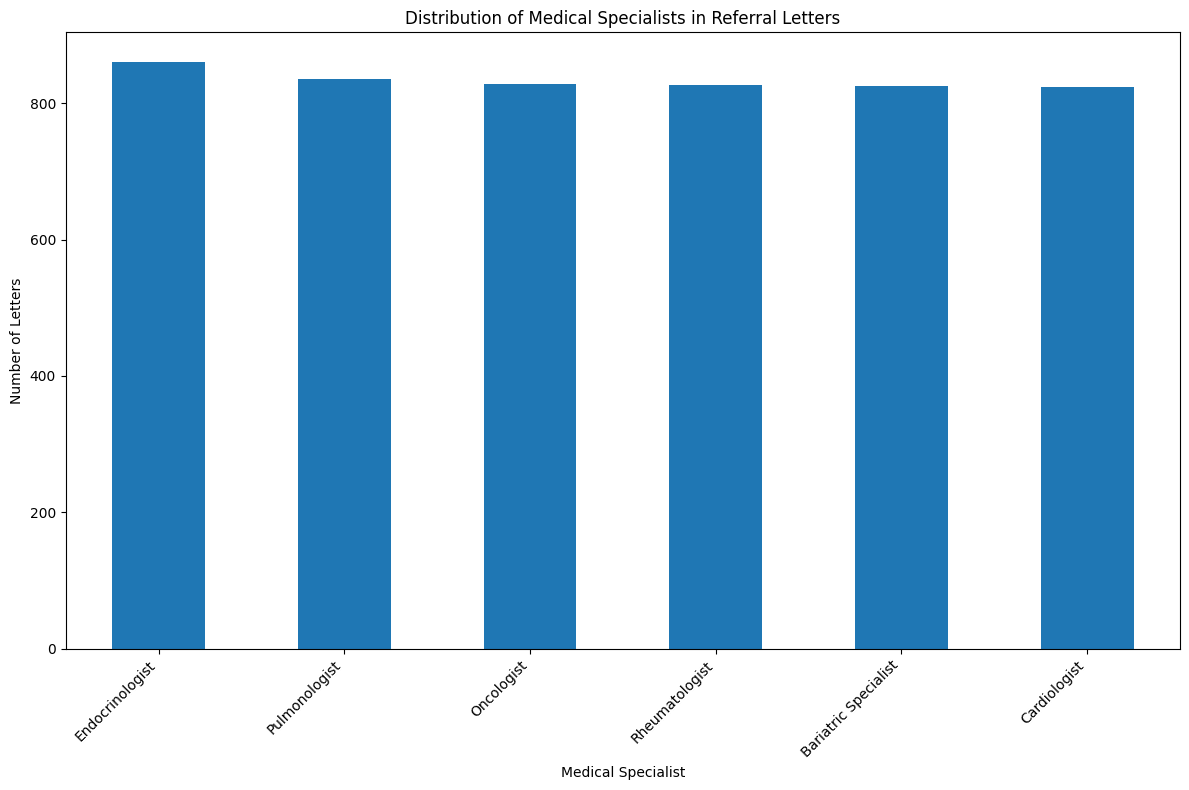


Class Balance Analysis:
Endocrinologist: 861 samples (17.2%)
Pulmonologist: 835 samples (16.7%)
Oncologist: 828 samples (16.6%)
Rheumatologist: 827 samples (16.5%)
Bariatric Specialist: 825 samples (16.5%)
Cardiologist: 824 samples (16.5%)


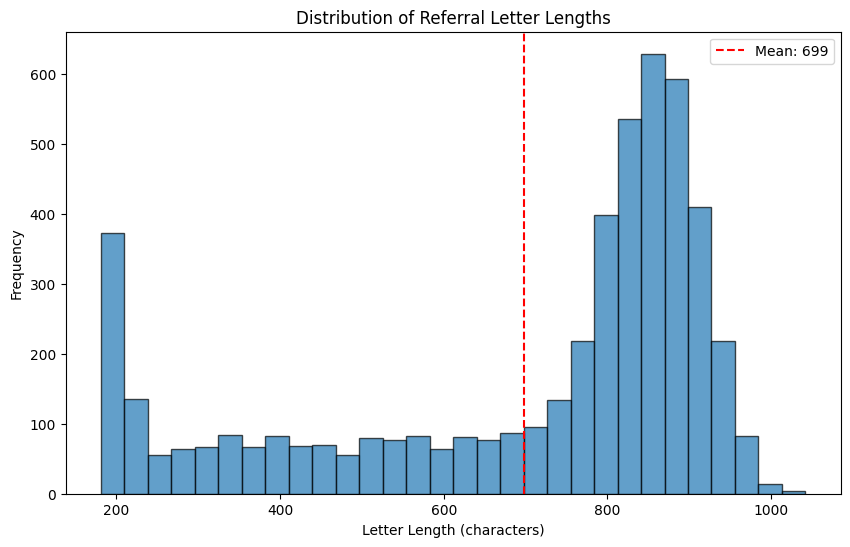


Letter Length Statistics:
count    5000.00000
mean      698.65640
std       241.14507
min       181.00000
25%       546.00000
50%       811.50000
75%       872.25000
max      1042.00000
Name: letter_length, dtype: float64


In [11]:
specialist_counts = df['assigned_specialist'].value_counts()
print("Specialist Distribution:")
print(specialist_counts)

plt.figure(figsize=(12, 8))
specialist_counts.plot(kind='bar')
plt.title('Distribution of Medical Specialists in Referral Letters')
plt.xlabel('Medical Specialist')
plt.ylabel('Number of Letters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nClass Balance Analysis:")
total_samples = len(df)
for specialist, count in specialist_counts.items():
    percentage = (count / total_samples) * 100
    print(f"{specialist}: {count} samples ({percentage:.1f}%)")

plt.figure(figsize=(10, 6))
plt.hist(df['letter_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Referral Letter Lengths')
plt.xlabel('Letter Length (characters)')
plt.ylabel('Frequency')
plt.axvline(df['letter_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["letter_length"].mean():.0f}')
plt.legend()
plt.show()

print(f"\nLetter Length Statistics:")
print(df['letter_length'].describe())

In [12]:
def preprocess_text_advanced(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\.,!?;:\-()]', '', text)
    text = re.sub(r'(\w)\1{3,}', r'\1\1', text)
    text = re.sub(r'\b\d+/\d+/\d+\b', ' DATE ', text)
    text = re.sub(r'\b\d{2,}\b', ' NUMBER ', text)
    text = re.sub(r'\bDear\s+\w+,?\b', 'Dear Colleague,', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRE:\s*', 'Regarding: ', text, flags=re.IGNORECASE)
    text = text.strip()
    if len(text) < 50:
        return ""
    return text

print("Applying preprocessing to referral letters...")
df['processed_letter'] = df['referral_letter'].apply(preprocess_text_advanced)

empty_letters = df[df['processed_letter'].str.len() == 0]
print(f"Empty letters after preprocessing: {len(empty_letters)}")

if len(empty_letters) > 0:
    df = df[df['processed_letter'].str.len() > 0].copy()
    print(f"Dataset shape after removing empty letters: {df.shape}")

specialist_counts = df['assigned_specialist'].value_counts()
print(f"\nOriginal specialist distribution:")
print(specialist_counts)

small_classes = specialist_counts[specialist_counts < CONFIG['MIN_SAMPLES_PER_CLASS']].index
print(f"\nClasses with < {CONFIG['MIN_SAMPLES_PER_CLASS']} samples (will be removed): {list(small_classes)}")

class_mapping = {
    'Geriatric Psychiatrist': 'Geriatrician',
    'Radiation Oncologist': 'Oncologist',
    'Cardiac Surgeon': 'Cardiologist',
}

df['assigned_specialist_mapped'] = df['assigned_specialist'].replace(class_mapping)

df_filtered = df[~df['assigned_specialist_mapped'].isin(small_classes)].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Specialist distribution after filtering and mapping:")
filtered_counts = df_filtered['assigned_specialist_mapped'].value_counts()
print(filtered_counts)

print(f"\nPreparing labels for classification...")
label_encoder = LabelEncoder()
df_filtered['specialist_label'] = label_encoder.fit_transform(df_filtered['assigned_specialist_mapped'])

label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print(f"Final label mapping:")
for label_id, specialist in label_mapping.items():
    count = filtered_counts[specialist]
    print(f"  {label_id}: {specialist} ({count} samples)")

print(f"\nNumber of unique specialists (classes): {len(label_encoder.classes_)}")
print(f"Final dataset shape: {df_filtered.shape}")

min_samples = filtered_counts.min()
max_samples = filtered_counts.max()
imbalance_ratio = max_samples / min_samples
print(f"\nClass balance analysis:")
print(f"  Min samples per class: {min_samples}")
print(f"  Max samples per class: {max_samples}")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}")

df = df_filtered.copy()

print(f"\nMemory optimization...")
memory_before = df.memory_usage(deep=True).sum() / 1024**2
df = df[['processed_letter', 'specialist_label', 'assigned_specialist_mapped']].copy()
memory_after = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memory usage reduced from {memory_before:.2f} MB to {memory_after:.2f} MB")

Applying preprocessing to referral letters...
Empty letters after preprocessing: 0

Original specialist distribution:
assigned_specialist
Endocrinologist         861
Pulmonologist           835
Oncologist              828
Rheumatologist          827
Bariatric Specialist    825
Cardiologist            824
Name: count, dtype: int64

Classes with < 30 samples (will be removed): []

Filtered dataset shape: (5000, 12)
Specialist distribution after filtering and mapping:
assigned_specialist_mapped
Endocrinologist         861
Pulmonologist           835
Oncologist              828
Rheumatologist          827
Bariatric Specialist    825
Cardiologist            824
Name: count, dtype: int64

Preparing labels for classification...
Final label mapping:
  0: Bariatric Specialist (825 samples)
  1: Cardiologist (824 samples)
  2: Endocrinologist (861 samples)
  3: Oncologist (828 samples)
  4: Pulmonologist (835 samples)
  5: Rheumatologist (827 samples)

Number of unique specialists (classes): 6
F

## 4. K-Fold Cross-Validation Configuration

Setting up the K-Fold Cross-Validation with BioClinical BERT optimized for Google Colab's GPU resources.

In [13]:
print(f"Loading BioClinical BERT tokenizer: {CONFIG['MODEL_NAME']}")
tokenizer = BertTokenizer.from_pretrained(CONFIG['MODEL_NAME'])
print(f"Tokenizer loaded. Vocabulary size: {len(tokenizer)}")

X = df['processed_letter'].values
y = df['specialist_label'].values

print(f"\nK-Fold setup:")
print(f"Total dataset size: {len(X)}")
print(f"Folds: {CONFIG['K_FOLDS']}")
print(f"Epochs per fold: {CONFIG['EPOCHS_PER_FOLD']}")
print(f"Batch size: {CONFIG['BATCH_SIZE']}")
print(f"Gradient accumulation: {CONFIG['ACCUMULATION_STEPS']} (effective batch size: {CONFIG['BATCH_SIZE'] * CONFIG['ACCUMULATION_STEPS']})")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y),
    y=y
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f"\nClass weights for {len(class_weights)} classes:")
for i, weight in enumerate(class_weights):
    specialist = label_mapping[i]
    count = filtered_counts[specialist]
    print(f"  {specialist}: weight={weight:.3f} (samples={count})")

def create_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights_np = 1.0 / class_counts
    sample_weights = class_weights_np[labels]
    sample_weights = sample_weights / sample_weights.sum() * len(sample_weights)
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

print(f"\nTesting weighted sampling strategy...")
sample_sampler = create_weighted_sampler(y)
print(f"Weighted sampler created for {len(y)} samples")

estimated_time_per_fold = 12
total_estimated_time = estimated_time_per_fold * CONFIG['K_FOLDS']
print(f"\nEstimated training time:")
print(f"~{estimated_time_per_fold} minutes per fold")
print(f"Total estimated time: ~{total_estimated_time} minutes ({total_estimated_time/60:.1f} hours)")

num_labels = len(label_mapping)
specialist_names = [label_mapping[i] for i in range(len(label_mapping))]

print(f"\nReady for training:")
print(f"  + Balanced class weights")
print(f"  + Weighted sampling")
print(f"  + Focal loss for imbalanced data")
print(f"  + {CONFIG['EPOCHS_PER_FOLD']} epochs per fold")
print(f"  + {num_labels} specialists on {device}!")

Loading BioClinical BERT tokenizer: emilyalsentzer/Bio_ClinicalBERT


vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Tokenizer loaded. Vocabulary size: 28996

K-Fold setup:
Total dataset size: 5000
Folds: 5
Epochs per fold: 15
Batch size: 3
Gradient accumulation: 12 (effective batch size: 36)

Class weights for 6 classes:
  Bariatric Specialist: weight=1.010 (samples=825)
  Cardiologist: weight=1.011 (samples=824)
  Endocrinologist: weight=0.968 (samples=861)
  Oncologist: weight=1.006 (samples=828)
  Pulmonologist: weight=0.998 (samples=835)
  Rheumatologist: weight=1.008 (samples=827)

Testing weighted sampling strategy...
Weighted sampler created for 5000 samples

Estimated training time:
~12 minutes per fold
Total estimated time: ~60 minutes (1.0 hours)

Ready for training:
  + Balanced class weights
  + Weighted sampling
  + Focal loss for imbalanced data
  + 15 epochs per fold
  + 6 specialists on cuda!


In [14]:
class ReferralLetterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment

    def __len__(self):
        return len(self.texts)

    def text_augmentation(self, text):
        if not self.augment or np.random.random() > 0.3:
            return text
        medical_synonyms = {
            'patient': ['individual', 'person', 'client'],
            'symptoms': ['signs', 'manifestations', 'indicators'],
            'treatment': ['therapy', 'intervention', 'management'],
            'condition': ['disorder', 'ailment', 'issue'],
            'examination': ['assessment', 'evaluation', 'review']
        }
        for original, synonyms in medical_synonyms.items():
            if original in text.lower() and np.random.random() > 0.7:
                synonym = np.random.choice(synonyms)
                text = re.sub(f'\\b{original}\\b', synonym, text, flags=re.IGNORECASE)
        return text

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        if self.augment:
            text = self.text_augmentation(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Testing dataset with augmentation...")
sample_dataset = ReferralLetterDataset(
    X[:5], y[:5], tokenizer, CONFIG['MAX_LENGTH'], augment=True
)

sample_sampler = create_weighted_sampler(y[:100])
sample_loader = DataLoader(
    ReferralLetterDataset(X[:100], y[:100], tokenizer, CONFIG['MAX_LENGTH']),
    batch_size=CONFIG['BATCH_SIZE'],
    sampler=sample_sampler
)

for batch in sample_loader:
    print(f"Batch input_ids shape: {batch['input_ids'].shape}")
    print(f"Batch attention_mask shape: {batch['attention_mask'].shape}")
    print(f"Batch labels shape: {batch['labels'].shape}")
    print(f"Label distribution in batch: {torch.bincount(batch['labels'])}")
    break

print("Dataset and weighted sampling ready!")

Testing dataset with augmentation...
Batch input_ids shape: torch.Size([3, 384])
Batch attention_mask shape: torch.Size([3, 384])
Batch labels shape: torch.Size([3])
Label distribution in batch: tensor([0, 1, 1, 1])
Dataset and weighted sampling ready!


## 5. BioClinical BERT Model Architecture

Creating the BioClinical BERT classifier optimized for Google Colab's GPU acceleration.

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class BertClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_rate=0.3, use_focal_loss=True):
        super(BertClassifier, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(
            bert_model_name,
            num_labels=num_classes,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True,
            hidden_dropout_prob=dropout_rate,
            attention_probs_dropout_prob=dropout_rate
        )
        self.use_focal_loss = use_focal_loss
        if use_focal_loss:
            self.loss_fn = FocalLoss(
                alpha=CONFIG['FOCAL_LOSS_ALPHA'],
                gamma=CONFIG['FOCAL_LOSS_GAMMA']
            )
        else:
            self.loss_fn = nn.CrossEntropyLoss(label_smoothing=CONFIG['LABEL_SMOOTHING'])
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits
        if self.use_focal_loss and labels is not None:
            loss = self.loss_fn(logits, labels)
        return type('ModelOutput', (), {
            'loss': loss,
            'logits': logits,
            'hidden_states': None,
            'attentions': None
        })()

def train_epoch(model, data_loader, optimizer, scheduler, device, accumulation_steps=1):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    optimizer.zero_grad()
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss / accumulation_steps
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        loss.backward()
        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIP'])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        total_loss += loss.item() * accumulation_steps
        current_accuracy = correct_predictions / total_samples
        progress_bar.set_postfix({
            'Loss': f'{loss.item() * accumulation_steps:.4f}',
            'Accuracy': f'{current_accuracy:.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    if len(data_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=CONFIG['GRADIENT_CLIP'])
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            current_accuracy = correct_predictions / total_samples
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Accuracy': f'{current_accuracy:.4f}'
            })
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy, all_predictions, all_labels, all_probs

print("BioClinical BERT model with focal loss ready!")
print(f"Key features:")
print(f"  + Focal loss for class imbalance (α={CONFIG['FOCAL_LOSS_ALPHA']}, γ={CONFIG['FOCAL_LOSS_GAMMA']})")
print(f"  + Gradient accumulation ({CONFIG['ACCUMULATION_STEPS']} steps)")
print(f"  + Label smoothing ({CONFIG['LABEL_SMOOTHING']})")
print(f"  + Dropout ({CONFIG['DROPOUT']})")
print(f"  + Ready for training on {device}!")

BioClinical BERT model with focal loss ready!
Key features:
  + Focal loss for class imbalance (α=0.3, γ=2.5)
  + Gradient accumulation (12 steps)
  + Label smoothing (0.05)
  + Dropout (0.2)
  + Ready for training on cuda!


## 6. K-Fold Cross-Validation Training

In [ ]:
 # Memory optimization and training configuration
torch.cuda.empty_cache()
gc.collect()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print("\n" + "="*70)
print("STARTING K-FOLD CROSS-VALIDATION TRAINING")
print("="*70)

# Use CONFIG as the single source of truth
MEMORY_CONFIG = CONFIG

def create_enhanced_scheduler(optimizer, num_training_steps, warmup_steps):
    return get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=num_training_steps,
        num_cycles=0.5
    )

class AdvancedEarlyStopping:
    def __init__(self, patience=MEMORY_CONFIG['PATIENCE'], min_delta=0.001, restore_best_weights=True,
                 reduce_lr_patience=3, reduce_lr_factor=0.5, min_lr=MEMORY_CONFIG['MIN_LR']):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.reduce_lr_patience = reduce_lr_patience
        self.reduce_lr_factor = reduce_lr_factor
        self.min_lr = min_lr
        self.best_score = None
        self.counter = 0
        self.lr_counter = 0
        self.best_weights = None
    def __call__(self, val_score, model, optimizer):
        if self.best_score is None:
            self.best_score = val_score
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        elif val_score < self.best_score + self.min_delta:
            self.counter += 1
            self.lr_counter += 1
            if self.lr_counter >= self.reduce_lr_patience:
                current_lr = optimizer.param_groups[0]['lr']
                new_lr = max(current_lr * self.reduce_lr_factor, self.min_lr)
                if new_lr < current_lr:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = new_lr
                    print(f"Reducing learning rate to {new_lr:.2e}")
                    self.lr_counter = 0
            if self.counter >= self.patience:
                if self.restore_best_weights and self.best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
        return False

class AdvancedTextAugmentation:
    def __init__(self):
        self.medical_synonyms = {
            'patient': ['individual', 'person', 'client', 'case'],
            'symptoms': ['signs', 'manifestations', 'indicators', 'presentations'],
            'treatment': ['therapy', 'intervention', 'management', 'care'],
            'condition': ['disorder', 'ailment', 'issue', 'problem'],
            'examination': ['assessment', 'evaluation', 'review', 'analysis'],
            'severe': ['serious', 'critical', 'acute', 'significant'],
            'chronic': ['persistent', 'ongoing', 'long-term', 'continuing'],
            'history': ['background', 'past', 'previous', 'prior']
        }
    def augment_text(self, text, augment_prob=MEMORY_CONFIG['AUGMENTATION_PROB']):
        if np.random.random() > augment_prob:
            return text
        words = text.split()
        augmented_words = []
        for word in words:
            w = word.lower().strip('.,!?;:')
            if w in self.medical_synonyms and np.random.random() > 0.7:
                synonym = np.random.choice(self.medical_synonyms[w])
                if word[0].isupper():
                    synonym = synonym.capitalize()
                augmented_words.append(word.replace(w, synonym))
            else:
                augmented_words.append(word)
        return ' '.join(augmented_words)

class EnhancedReferralLetterDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment
        self.augmentor = AdvancedTextAugmentation()
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        if self.augment:
            text = self.augmentor.augment_text(text)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def implement_gradual_unfreezing(model, epoch, total_epochs):
    num_layers = 12
    unfreeze_at_epoch = total_epochs // 3
    if epoch < unfreeze_at_epoch:
        for param in model.bert.bert.encoder.parameters():
            param.requires_grad = False
    else:
        layers_to_unfreeze = min(num_layers, (epoch - unfreeze_at_epoch + 1) * 2)
        for i in range(num_layers - layers_to_unfreeze, num_layers):
            for param in model.bert.bert.encoder.layer[i].parameters():
                param.requires_grad = True
        print(f"Epoch {epoch}: Unfrozen top {layers_to_unfreeze} layers")

def save_checkpoint(model, optimizer, scheduler, epoch, fold, loss, accuracy):
    checkpoint = {
        'epoch': epoch,
        'fold': fold,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'config': MEMORY_CONFIG
    }
    path = f'checkpoint_fold_{fold}_epoch_{epoch}.pt'
    torch.save(checkpoint, path)
    return path

def train_epoch_enhanced(model, data_loader, optimizer, scheduler, device, accumulation_steps=1):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    optimizer.zero_grad()
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss / accumulation_steps
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        loss.backward()
        if (step + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MEMORY_CONFIG['GRADIENT_CLIP'])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        total_loss += loss.item() * accumulation_steps
        progress_bar.set_postfix({
            'Loss': f'{loss.item() * accumulation_steps:.4f}',
            'Acc': f'{correct_predictions / total_samples:.4f}',
            'LR': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    if len(data_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=MEMORY_CONFIG['GRADIENT_CLIP'])
        optimizer.step()
        optimizer.zero_grad()
    return total_loss / len(data_loader), correct_predictions / total_samples

# memory helpers

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def get_memory_usage():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / (1024**3), torch.cuda.memory_reserved() / (1024**3)
    return 0, 0

def train_epoch_mixed_precision(model, dataloader, optimizer, scheduler, device, scaler, accumulation_steps=1):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    optimizer.zero_grad()
    for i, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask, labels)
            loss = outputs.loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()
        total_loss += loss.item() * accumulation_steps
        with torch.no_grad():
            preds = torch.argmax(outputs.logits, dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        del input_ids, attention_mask, labels, outputs, loss
        if i % 50 == 0:
            torch.cuda.empty_cache()
    return total_loss / len(dataloader), correct / total

skf = StratifiedKFold(n_splits=MEMORY_CONFIG['K_FOLDS'], shuffle=True, random_state=42)

results = {
    'fold_accuracies': [],
    'fold_f1_scores': [],
    'fold_precisions': [],
    'fold_recalls': [],
    'fold_losses': [],
    'fold_val_losses': [],
    'training_times': [],
    'best_epochs': [],
    'confusion_matrices': [],
    'class_reports': []
}

clear_memory()
alloc, reserv = get_memory_usage()
print(f"Initial GPU mem - Alloc: {alloc:.2f}GB, Reserv: {reserv:.2f}GB")
print("Training configuration:")
print(f"  Epochs: {MEMORY_CONFIG['EPOCHS_PER_FOLD']}")
print(f"  Max length: {MEMORY_CONFIG['MAX_LENGTH']}")
print(f"  Batch size: {MEMORY_CONFIG['BATCH_SIZE']}")
print(f"  Accumulation: {MEMORY_CONFIG['ACCUMULATION_STEPS']}")
print(f"  Effective batch: {MEMORY_CONFIG['BATCH_SIZE'] * MEMORY_CONFIG['ACCUMULATION_STEPS']}")
print(f"  Mixed precision: {MEMORY_CONFIG['USE_MIXED_PRECISION']}")

est_per_fold = 25
total_est = est_per_fold * MEMORY_CONFIG['K_FOLDS']
print(f"Estimated time: ~{est_per_fold} min/fold (~{total_est/60:.1f} hrs total)")

kfold_start = time.time()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*22} FOLD {fold+1}/{MEMORY_CONFIG['K_FOLDS']} {'='*22}")
    clear_memory()
    fold_start = time.time()
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]
    print(f"Train: {len(X_tr)}  Val: {len(X_va)}")
    train_ds = EnhancedReferralLetterDataset(X_tr, y_tr, tokenizer, MEMORY_CONFIG['MAX_LENGTH'], augment=True)
    val_ds = EnhancedReferralLetterDataset(X_va, y_va, tokenizer, MEMORY_CONFIG['MAX_LENGTH'], augment=False)
    sampler = create_weighted_sampler(y_tr) if MEMORY_CONFIG['USE_WEIGHTED_SAMPLING'] else None
    train_loader = DataLoader(train_ds, batch_size=MEMORY_CONFIG['BATCH_SIZE'], sampler=sampler, shuffle=(sampler is None))
    val_loader = DataLoader(val_ds, batch_size=MEMORY_CONFIG['BATCH_SIZE'], shuffle=False)
    model = BertClassifier(MEMORY_CONFIG['MODEL_NAME'], num_labels, dropout_rate=MEMORY_CONFIG['DROPOUT'], use_focal_loss=True).to(device)
    scaler = torch.cuda.amp.GradScaler() if MEMORY_CONFIG['USE_MIXED_PRECISION'] else None
    optimizer = AdamW(model.parameters(), lr=MEMORY_CONFIG['LEARNING_RATE'], weight_decay=MEMORY_CONFIG['WEIGHT_DECAY'], eps=1e-8)
    total_steps = len(train_loader) * MEMORY_CONFIG['EPOCHS_PER_FOLD'] // MEMORY_CONFIG['ACCUMULATION_STEPS']
    warmup_steps = int(total_steps * MEMORY_CONFIG['WARMUP_RATIO'])
    scheduler = create_enhanced_scheduler(optimizer, total_steps, warmup_steps)
    early_stop = AdvancedEarlyStopping()
    best_acc = 0
    best_loss = float('inf')
    best_epoch = 0
    for epoch in range(MEMORY_CONFIG['EPOCHS_PER_FOLD']):
        print(f"  Epoch {epoch+1}/{MEMORY_CONFIG['EPOCHS_PER_FOLD']}")
        if epoch > 0:
            clear_memory()
        if MEMORY_CONFIG['USE_GRADUAL_UNFREEZING']:
            implement_gradual_unfreezing(model, epoch, MEMORY_CONFIG['EPOCHS_PER_FOLD'])
        if MEMORY_CONFIG['USE_MIXED_PRECISION']:
            tr_loss, tr_acc = train_epoch_mixed_precision(model, train_loader, optimizer, scheduler, device, scaler, accumulation_steps=MEMORY_CONFIG['ACCUMULATION_STEPS'])
        else:
            tr_loss, tr_acc = train_epoch_enhanced(model, train_loader, optimizer, scheduler, device, accumulation_steps=MEMORY_CONFIG['ACCUMULATION_STEPS'])
        va_loss, va_acc, va_preds, va_labels, va_probs = eval_model(model, val_loader, device)
        print(f"    Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}")
        if va_acc > best_acc:
            best_acc = va_acc
            best_loss = va_loss
            best_epoch = epoch + 1
            best_preds = va_preds
            best_labels = va_labels
            best_probs = va_probs
            print(f"    >> New best acc {best_acc:.4f}")
            if MEMORY_CONFIG['SAVE_CHECKPOINTS'] and epoch % 3 == 0:
                path = save_checkpoint(model, optimizer, scheduler, epoch, fold, va_loss, va_acc)
                print(f"    Saved {path}")
        if early_stop(va_acc, model, optimizer):
            print(f"    Early stopping at epoch {epoch+1}")
            break
    fold_f1 = f1_score(best_labels, best_preds, average='weighted')
    fold_prec = precision_score(best_labels, best_preds, average='weighted', zero_division=0)
    fold_rec = recall_score(best_labels, best_preds, average='weighted', zero_division=0)
    fold_cm = confusion_matrix(best_labels, best_preds)
    fold_report = classification_report(best_labels, best_preds, target_names=specialist_names, output_dict=True)
    fold_time = time.time() - fold_start
    results['fold_accuracies'].append(best_acc)
    results['fold_f1_scores'].append(fold_f1)
    results['fold_precisions'].append(fold_prec)
    results['fold_recalls'].append(fold_rec)
    results['fold_losses'].append(best_loss)
    results['training_times'].append(fold_time)
    results['best_epochs'].append(best_epoch)
    results['confusion_matrices'].append(fold_cm)
    results['class_reports'].append(fold_report)
    print(f"  Fold {fold+1} Best Acc: {best_acc:.4f} F1: {fold_f1:.4f} Time: {fold_time/60:.1f}m (epoch {best_epoch})")
    del model, optimizer, scheduler
    if scaler:
        del scaler
    del train_loader, val_loader, train_ds, val_ds
    clear_memory()

total_time = time.time() - kfold_start
print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Total time: {total_time/60:.1f} minutes")
clear_memory()
final_alloc, final_res = get_memory_usage()
print(f"Final GPU mem - Alloc: {final_alloc:.2f}GB, Reserv: {final_res:.2f}GB")


STARTING K-FOLD CROSS-VALIDATION TRAINING
Initial GPU mem - Alloc: 0.00GB, Reserv: 0.00GB
Training configuration:
  Epochs: 15
  Max length: 384
  Batch size: 3
  Accumulation: 12
  Effective batch: 36
  Mixed precision: True
Estimated time: ~25 min/fold (~2.1 hrs total)

====================== FOLD 1/5 ======================
Train: 4000  Val: 1000


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/15


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3632 Acc: 0.1765 | Val Loss: 0.3389 Acc: 0.1970
    >> New best acc 0.1970
    Saved checkpoint_fold_0_epoch_0.pt
  Epoch 2/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3449 Acc: 0.1742 | Val Loss: 0.3353 Acc: 0.2130
    >> New best acc 0.2130
  Epoch 3/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3406 Acc: 0.1958 | Val Loss: 0.3324 Acc: 0.2180
    >> New best acc 0.2180
  Epoch 4/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3348 Acc: 0.2125 | Val Loss: 0.3280 Acc: 0.2380
    >> New best acc 0.2380
    Saved checkpoint_fold_0_epoch_3.pt
  Epoch 5/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3283 Acc: 0.2525 | Val Loss: 0.3223 Acc: 0.3350
    >> New best acc 0.3350
  Epoch 6/15
Epoch 5: Unfrozen top 2 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.2509 Acc: 0.4650 | Val Loss: 0.1889 Acc: 0.5930
    >> New best acc 0.5930
  Epoch 7/15
Epoch 6: Unfrozen top 4 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1807 Acc: 0.5948 | Val Loss: 0.1779 Acc: 0.6080
    >> New best acc 0.6080
    Saved checkpoint_fold_0_epoch_6.pt
  Epoch 8/15
Epoch 7: Unfrozen top 6 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1693 Acc: 0.6218 | Val Loss: 0.1770 Acc: 0.6140
    >> New best acc 0.6140
  Epoch 9/15
Epoch 8: Unfrozen top 8 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1672 Acc: 0.6332 | Val Loss: 0.1724 Acc: 0.6140
  Epoch 10/15
Epoch 9: Unfrozen top 10 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1542 Acc: 0.6538 | Val Loss: 0.1740 Acc: 0.6200
    >> New best acc 0.6200
    Saved checkpoint_fold_0_epoch_9.pt
  Epoch 11/15
Epoch 10: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1427 Acc: 0.6730 | Val Loss: 0.1744 Acc: 0.6290
    >> New best acc 0.6290
  Epoch 12/15
Epoch 11: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1393 Acc: 0.6757 | Val Loss: 0.1762 Acc: 0.6170
  Epoch 13/15
Epoch 12: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1391 Acc: 0.6777 | Val Loss: 0.1774 Acc: 0.6170
Reducing learning rate to 5.17e-07
  Epoch 14/15
Epoch 13: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1339 Acc: 0.6857 | Val Loss: 0.1762 Acc: 0.6190
  Epoch 15/15
Epoch 14: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1376 Acc: 0.6793 | Val Loss: 0.1765 Acc: 0.6170
  Fold 1 Best Acc: 0.6290 F1: 0.6360 Time: 27.3m (epoch 11)

====================== FOLD 2/5 ======================
Train: 4000  Val: 1000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3522 Acc: 0.1675 | Val Loss: 0.3399 Acc: 0.1730
    >> New best acc 0.1730
    Saved checkpoint_fold_1_epoch_0.pt
  Epoch 2/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3448 Acc: 0.1757 | Val Loss: 0.3356 Acc: 0.2200
    >> New best acc 0.2200
  Epoch 3/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3401 Acc: 0.1958 | Val Loss: 0.3320 Acc: 0.2490
    >> New best acc 0.2490
  Epoch 4/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3342 Acc: 0.2105 | Val Loss: 0.3260 Acc: 0.2930
    >> New best acc 0.2930
    Saved checkpoint_fold_1_epoch_3.pt
  Epoch 5/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3285 Acc: 0.2447 | Val Loss: 0.3175 Acc: 0.3560
    >> New best acc 0.3560
  Epoch 6/15
Epoch 5: Unfrozen top 2 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.2533 Acc: 0.4490 | Val Loss: 0.1930 Acc: 0.5820
    >> New best acc 0.5820
  Epoch 7/15
Epoch 6: Unfrozen top 4 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1830 Acc: 0.6025 | Val Loss: 0.1785 Acc: 0.6040
    >> New best acc 0.6040
    Saved checkpoint_fold_1_epoch_6.pt
  Epoch 8/15
Epoch 7: Unfrozen top 6 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1648 Acc: 0.6302 | Val Loss: 0.1715 Acc: 0.6170
    >> New best acc 0.6170
  Epoch 9/15
Epoch 8: Unfrozen top 8 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1587 Acc: 0.6438 | Val Loss: 0.1699 Acc: 0.6190
    >> New best acc 0.6190
  Epoch 10/15
Epoch 9: Unfrozen top 10 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1549 Acc: 0.6458 | Val Loss: 0.1723 Acc: 0.6220
    >> New best acc 0.6220
    Saved checkpoint_fold_1_epoch_9.pt
  Epoch 11/15
Epoch 10: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1495 Acc: 0.6605 | Val Loss: 0.1721 Acc: 0.6280
    >> New best acc 0.6280
  Epoch 12/15
Epoch 11: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1445 Acc: 0.6685 | Val Loss: 0.1722 Acc: 0.6310
    >> New best acc 0.6310
  Epoch 13/15
Epoch 12: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1350 Acc: 0.6945 | Val Loss: 0.1727 Acc: 0.6190
  Epoch 14/15
Epoch 13: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1405 Acc: 0.6763 | Val Loss: 0.1726 Acc: 0.6300
  Epoch 15/15
Epoch 14: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1346 Acc: 0.6923 | Val Loss: 0.1726 Acc: 0.6270
  Fold 2 Best Acc: 0.6310 F1: 0.6357 Time: 28.1m (epoch 12)

====================== FOLD 3/5 ======================
Train: 4000  Val: 1000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3548 Acc: 0.1670 | Val Loss: 0.3419 Acc: 0.1710
    >> New best acc 0.1710
    Saved checkpoint_fold_2_epoch_0.pt
  Epoch 2/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3440 Acc: 0.1772 | Val Loss: 0.3391 Acc: 0.1940
    >> New best acc 0.1940
  Epoch 3/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3402 Acc: 0.2032 | Val Loss: 0.3328 Acc: 0.2630
    >> New best acc 0.2630
  Epoch 4/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3350 Acc: 0.2243 | Val Loss: 0.3287 Acc: 0.2870
    >> New best acc 0.2870
    Saved checkpoint_fold_2_epoch_3.pt
  Epoch 5/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3293 Acc: 0.2430 | Val Loss: 0.3230 Acc: 0.3040
    >> New best acc 0.3040
  Epoch 6/15
Epoch 5: Unfrozen top 2 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.2548 Acc: 0.4407 | Val Loss: 0.1912 Acc: 0.6040
    >> New best acc 0.6040
  Epoch 7/15
Epoch 6: Unfrozen top 4 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1867 Acc: 0.5907 | Val Loss: 0.1760 Acc: 0.6240
    >> New best acc 0.6240
    Saved checkpoint_fold_2_epoch_6.pt
  Epoch 8/15
Epoch 7: Unfrozen top 6 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1754 Acc: 0.6132 | Val Loss: 0.1678 Acc: 0.6310
    >> New best acc 0.6310
  Epoch 9/15
Epoch 8: Unfrozen top 8 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1603 Acc: 0.6428 | Val Loss: 0.1677 Acc: 0.6360
    >> New best acc 0.6360
  Epoch 10/15
Epoch 9: Unfrozen top 10 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1462 Acc: 0.6707 | Val Loss: 0.1677 Acc: 0.6450
    >> New best acc 0.6450
    Saved checkpoint_fold_2_epoch_9.pt
  Epoch 11/15
Epoch 10: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1507 Acc: 0.6522 | Val Loss: 0.1654 Acc: 0.6290
  Epoch 12/15
Epoch 11: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1455 Acc: 0.6645 | Val Loss: 0.1676 Acc: 0.6310
  Epoch 13/15
Epoch 12: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1408 Acc: 0.6713 | Val Loss: 0.1673 Acc: 0.6420
Reducing learning rate to 5.17e-07
  Epoch 14/15
Epoch 13: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1416 Acc: 0.6755 | Val Loss: 0.1674 Acc: 0.6420
  Epoch 15/15
Epoch 14: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1400 Acc: 0.6707 | Val Loss: 0.1674 Acc: 0.6420
  Fold 3 Best Acc: 0.6450 F1: 0.6464 Time: 28.8m (epoch 10)

====================== FOLD 4/5 ======================
Train: 4000  Val: 1000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3685 Acc: 0.1638 | Val Loss: 0.3417 Acc: 0.1920
    >> New best acc 0.1920
    Saved checkpoint_fold_3_epoch_0.pt
  Epoch 2/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3433 Acc: 0.1885 | Val Loss: 0.3399 Acc: 0.1730
  Epoch 3/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3403 Acc: 0.1995 | Val Loss: 0.3342 Acc: 0.1890
  Epoch 4/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3346 Acc: 0.2117 | Val Loss: 0.3288 Acc: 0.2660
    >> New best acc 0.2660
    Saved checkpoint_fold_3_epoch_3.pt
  Epoch 5/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3277 Acc: 0.2377 | Val Loss: 0.3231 Acc: 0.2700
    >> New best acc 0.2700
  Epoch 6/15
Epoch 5: Unfrozen top 2 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.2479 Acc: 0.4632 | Val Loss: 0.1897 Acc: 0.5930
    >> New best acc 0.5930
  Epoch 7/15
Epoch 6: Unfrozen top 4 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1859 Acc: 0.5992 | Val Loss: 0.1728 Acc: 0.6150
    >> New best acc 0.6150
    Saved checkpoint_fold_3_epoch_6.pt
  Epoch 8/15
Epoch 7: Unfrozen top 6 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1663 Acc: 0.6252 | Val Loss: 0.1729 Acc: 0.6170
    >> New best acc 0.6170
  Epoch 9/15
Epoch 8: Unfrozen top 8 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1602 Acc: 0.6360 | Val Loss: 0.1702 Acc: 0.6240
    >> New best acc 0.6240
  Epoch 10/15
Epoch 9: Unfrozen top 10 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1515 Acc: 0.6542 | Val Loss: 0.1747 Acc: 0.6200
Reducing learning rate to 2.92e-06
  Epoch 11/15
Epoch 10: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1453 Acc: 0.6623 | Val Loss: 0.1732 Acc: 0.6180
  Epoch 12/15
Epoch 11: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1430 Acc: 0.6727 | Val Loss: 0.1747 Acc: 0.6310
    >> New best acc 0.6310
  Epoch 13/15
Epoch 12: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1435 Acc: 0.6705 | Val Loss: 0.1729 Acc: 0.6200
  Epoch 14/15
Epoch 13: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1368 Acc: 0.6825 | Val Loss: 0.1731 Acc: 0.6240
Reducing learning rate to 1.33e-07
  Epoch 15/15
Epoch 14: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1369 Acc: 0.6905 | Val Loss: 0.1728 Acc: 0.6180
  Fold 4 Best Acc: 0.6310 F1: 0.6309 Time: 27.6m (epoch 12)

====================== FOLD 5/5 ======================
Train: 4000  Val: 1000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Epoch 1/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3568 Acc: 0.1613 | Val Loss: 0.3400 Acc: 0.1980
    >> New best acc 0.1980
    Saved checkpoint_fold_4_epoch_0.pt
  Epoch 2/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3453 Acc: 0.1777 | Val Loss: 0.3364 Acc: 0.2250
    >> New best acc 0.2250
  Epoch 3/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3418 Acc: 0.1925 | Val Loss: 0.3328 Acc: 0.2480
    >> New best acc 0.2480
  Epoch 4/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3333 Acc: 0.2338 | Val Loss: 0.3273 Acc: 0.3140
    >> New best acc 0.3140
    Saved checkpoint_fold_4_epoch_3.pt
  Epoch 5/15


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.3279 Acc: 0.2547 | Val Loss: 0.3211 Acc: 0.3070
  Epoch 6/15
Epoch 5: Unfrozen top 2 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.2570 Acc: 0.4482 | Val Loss: 0.1923 Acc: 0.5800
    >> New best acc 0.5800
  Epoch 7/15
Epoch 6: Unfrozen top 4 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1867 Acc: 0.5960 | Val Loss: 0.1761 Acc: 0.6010
    >> New best acc 0.6010
    Saved checkpoint_fold_4_epoch_6.pt
  Epoch 8/15
Epoch 7: Unfrozen top 6 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1689 Acc: 0.6255 | Val Loss: 0.1731 Acc: 0.6180
    >> New best acc 0.6180
  Epoch 9/15
Epoch 8: Unfrozen top 8 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1626 Acc: 0.6350 | Val Loss: 0.1731 Acc: 0.6220
    >> New best acc 0.6220
  Epoch 10/15
Epoch 9: Unfrozen top 10 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1572 Acc: 0.6442 | Val Loss: 0.1695 Acc: 0.6290
    >> New best acc 0.6290
    Saved checkpoint_fold_4_epoch_9.pt
  Epoch 11/15
Epoch 10: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1475 Acc: 0.6660 | Val Loss: 0.1702 Acc: 0.6360
    >> New best acc 0.6360
  Epoch 12/15
Epoch 11: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1449 Acc: 0.6717 | Val Loss: 0.1701 Acc: 0.6400
    >> New best acc 0.6400
  Epoch 13/15
Epoch 12: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1410 Acc: 0.6803 | Val Loss: 0.1709 Acc: 0.6370
  Epoch 14/15
Epoch 13: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1416 Acc: 0.6665 | Val Loss: 0.1715 Acc: 0.6360
Reducing learning rate to 1.33e-07
  Epoch 15/15
Epoch 14: Unfrozen top 12 layers


Validation:   0%|          | 0/334 [00:00<?, ?it/s]

    Train Loss: 0.1446 Acc: 0.6630 | Val Loss: 0.1713 Acc: 0.6370
  Fold 5 Best Acc: 0.6400 F1: 0.6404 Time: 28.6m (epoch 12)

TRAINING COMPLETE
Total time: 140.5 minutes
Final GPU mem - Alloc: 0.42GB, Reserv: 0.54GB


## 7. Results Analysis and Download


K-FOLD CROSS-VALIDATION RESULTS ANALYSIS

K-FOLD CROSS-VALIDATION SUMMARY:
Metric          Mean       Std Dev    Min        Max       
----------------------------------------------------------------------
Accuracy        0.6352     0.0062     0.6290     0.6450    
F1-Score        0.6379     0.0052     0.6309     0.6464    
Precision       0.6549     0.0051     0.6449     0.6591    
Recall          0.6352     0.0062     0.6290     0.6450    

FOLD-BY-FOLD RESULTS:
Fold   Accuracy   F1-Score   Precision    Recall     Best Epoch   Time (s)  
------------------------------------------------------------------------------------------
1      0.6290     0.6360     0.6571       0.6290     11           1638.7    
2      0.6310     0.6357     0.6591       0.6310     12           1688.2    
3      0.6450     0.6464     0.6556       0.6450     10           1730.2    
4      0.6310     0.6309     0.6449       0.6310     12           1653.5    
5      0.6400     0.6404     0.6578       0.6400     1

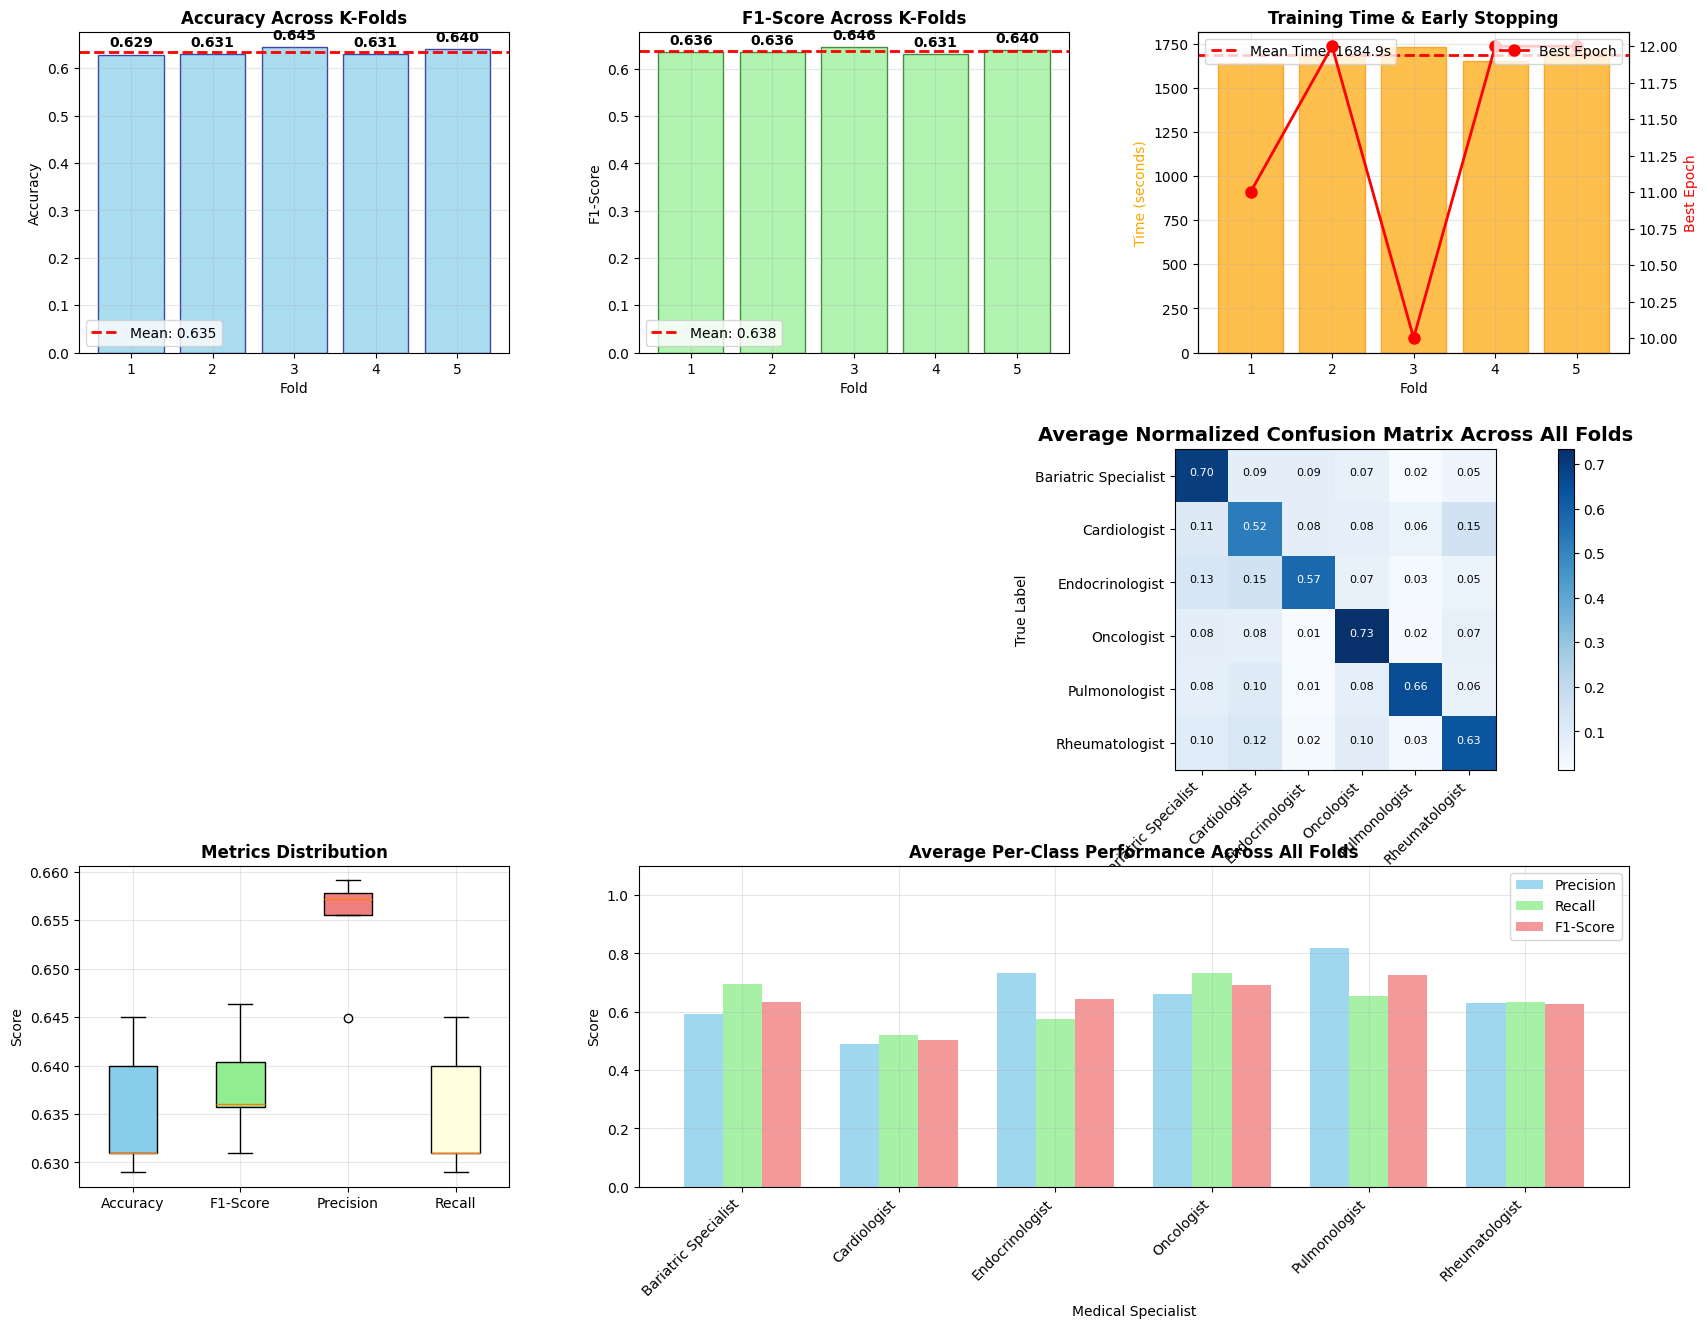


CONFIDENCE INTERVALS (95%):
Accuracy: 0.6352 ± 0.0059 [0.6293, 0.6411]
F1-Score: 0.6379 ± 0.0049 [0.6329, 0.6428]

PERFORMANCE SUMMARY:
  >> Mean Accuracy: 63.5%
  >> Mean F1-Score: 63.8%
  >> Average Training Time: 1684.9s per fold
  >> Average Early Stopping: epoch 11.4
  >> Standard Deviation: ±0.6%

KEY FEATURES USED:
  + Class balancing with focal loss
  + Weighted sampling for minority classes
  + 15 epochs per fold with early stopping
  + Gradient accumulation: effective batch size 36
  + Mixed precision training
  + Advanced text preprocessing
  + Dropout: 0.2


In [ ]:
print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION RESULTS ANALYSIS")
print("="*70)

mean_accuracy = np.mean(results['fold_accuracies'])
std_accuracy = np.std(results['fold_accuracies'])
mean_f1 = np.mean(results['fold_f1_scores'])
std_f1 = np.std(results['fold_f1_scores'])
mean_precision = np.mean(results['fold_precisions'])
std_precision = np.std(results['fold_precisions'])
mean_recall = np.mean(results['fold_recalls'])
std_recall = np.std(results['fold_recalls'])
mean_time = np.mean(results['training_times'])
mean_best_epoch = np.mean(results['best_epochs'])

print(f"\nK-FOLD CROSS-VALIDATION SUMMARY:")
print(f"{'Metric':<15} {'Mean':<10} {'Std Dev':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)

print(f"{'Accuracy':<15} {mean_accuracy:<10.4f} {std_accuracy:<10.4f} {min(results['fold_accuracies']):<10.4f} {max(results['fold_accuracies']):<10.4f}")
print(f"{'F1-Score':<15} {mean_f1:<10.4f} {std_f1:<10.4f} {min(results['fold_f1_scores']):<10.4f} {max(results['fold_f1_scores']):<10.4f}")
print(f"{'Precision':<15} {mean_precision:<10.4f} {std_precision:<10.4f} {min(results['fold_precisions']):<10.4f} {max(results['fold_precisions']):<10.4f}")
print(f"{'Recall':<15} {mean_recall:<10.4f} {std_recall:<10.4f} {min(results['fold_recalls']):<10.4f} {max(results['fold_recalls']):<10.4f}")

print(f"\nFOLD-BY-FOLD RESULTS:")
print(f"{'Fold':<6} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<12} {'Recall':<10} {'Best Epoch':<12} {'Time (s)':<10}")
print("-" * 90)
for i in range(MEMORY_CONFIG['K_FOLDS']):
    print(f"{i+1:<6} {results['fold_accuracies'][i]:<10.4f} {results['fold_f1_scores'][i]:<10.4f} "
          f"{results['fold_precisions'][i]:<12.4f} {results['fold_recalls'][i]:<10.4f} "
          f"{results['best_epochs'][i]:<12} {results['training_times'][i]:<10.1f}")

fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fold_numbers = list(range(1, MEMORY_CONFIG['K_FOLDS'] + 1))
ax1 = fig.add_subplot(gs[0, 0])
bars1 = ax1.bar(fold_numbers, results['fold_accuracies'], alpha=0.7, color='skyblue', edgecolor='navy')
ax1.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')
ax1.set_title('Accuracy Across K-Folds', fontweight='bold')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)
for bar, acc in zip(bars1, results['fold_accuracies']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(fold_numbers, results['fold_f1_scores'], alpha=0.7, color='lightgreen', edgecolor='darkgreen')
ax2.axhline(y=mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1:.3f}')
ax2.set_title('F1-Score Across K-Folds', fontweight='bold')
ax2.set_xlabel('Fold')
ax2.set_ylabel('F1-Score')
ax2.legend()
ax2.grid(True, alpha=0.3)
for bar, f1 in zip(bars2, results['fold_f1_scores']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.bar(fold_numbers, results['training_times'], alpha=0.7, color='orange', edgecolor='darkorange')
ax3_twin = ax3.twinx()
ax3_twin.plot(fold_numbers, results['best_epochs'], 'ro-', linewidth=2, markersize=8, label='Best Epoch')
ax3.axhline(y=mean_time, color='red', linestyle='--', linewidth=2, label=f'Mean Time: {mean_time:.1f}s')
ax3.set_title('Training Time & Early Stopping', fontweight='bold')
ax3.set_xlabel('Fold')
ax3.set_ylabel('Time (seconds)', color='orange')
ax3_twin.set_ylabel('Best Epoch', color='red')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, :])
avg_cm = np.mean(results['confusion_matrices'], axis=0)
normalized_cm = avg_cm / avg_cm.sum(axis=1)[:, np.newaxis]
im = ax4.imshow(normalized_cm, interpolation='nearest', cmap='Blues')
ax4.set_title('Average Normalized Confusion Matrix Across All Folds', fontweight='bold', fontsize=14)
tick_marks = np.arange(len(specialist_names))
ax4.set_xticks(tick_marks)
ax4.set_yticks(tick_marks)
ax4.set_xticklabels(specialist_names, rotation=45, ha='right')
ax4.set_yticklabels(specialist_names)
ax4.set_xlabel('Predicted Label')
ax4.set_ylabel('True Label')
thresh = normalized_cm.max() / 2.
for i, j in np.ndindex(normalized_cm.shape):
    ax4.text(j, i, f'{normalized_cm[i, j]:.2f}',
             horizontalalignment="center",
             color="white" if normalized_cm[i, j] > thresh else "black",
             fontsize=8)
plt.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

ax5 = fig.add_subplot(gs[2, 0])
metrics_data = [
    results['fold_accuracies'],
    results['fold_f1_scores'],
    results['fold_precisions'],
    results['fold_recalls']
]
box_plot = ax5.boxplot(metrics_data, labels=['Accuracy', 'F1-Score', 'Precision', 'Recall'], patch_artist=True)
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
ax5.set_title('Metrics Distribution', fontweight='bold')
ax5.set_ylabel('Score')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1:])
avg_class_metrics = {'precision': [], 'recall': [], 'f1-score': []}
for specialist in specialist_names:
    precisions = [report[specialist]['precision'] for report in results['class_reports'] if specialist in report]
    recalls = [report[specialist]['recall'] for report in results['class_reports'] if specialist in report]
    f1s = [report[specialist]['f1-score'] for report in results['class_reports'] if specialist in report]
    avg_class_metrics['precision'].append(np.mean(precisions) if precisions else 0)
    avg_class_metrics['recall'].append(np.mean(recalls) if recalls else 0)
    avg_class_metrics['f1-score'].append(np.mean(f1s) if f1s else 0)

x_pos = np.arange(len(specialist_names))
width = 0.25
ax6.bar(x_pos - width, avg_class_metrics['precision'], width, label='Precision', alpha=0.8, color='skyblue')
ax6.bar(x_pos, avg_class_metrics['recall'], width, label='Recall', alpha=0.8, color='lightgreen')
ax6.bar(x_pos + width, avg_class_metrics['f1-score'], width, label='F1-Score', alpha=0.8, color='lightcoral')
ax6.set_title('Average Per-Class Performance Across All Folds', fontweight='bold')
ax6.set_xlabel('Medical Specialist')
ax6.set_ylabel('Score')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(specialist_names, rotation=45, ha='right')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

confidence_level = 0.95
if MEMORY_CONFIG['K_FOLDS'] > 2:
    t_values = {3: 2.776, 4: 2.353, 5: 2.132, 6: 2.015, 7: 1.943, 8: 1.895}
    t_value = t_values.get(MEMORY_CONFIG['K_FOLDS'], 2.0)
    margin_of_error_acc = t_value * (std_accuracy / np.sqrt(MEMORY_CONFIG['K_FOLDS']))
    margin_of_error_f1 = t_value * (std_f1 / np.sqrt(MEMORY_CONFIG['K_FOLDS']))
    print(f"\nCONFIDENCE INTERVALS (95%):")
    print(f"Accuracy: {mean_accuracy:.4f} ± {margin_of_error_acc:.4f} [{mean_accuracy - margin_of_error_acc:.4f}, {mean_accuracy + margin_of_error_acc:.4f}]")
    print(f"F1-Score: {mean_f1:.4f} ± {margin_of_error_f1:.4f} [{mean_f1 - margin_of_error_f1:.4f}, {mean_f1 + margin_of_error_f1:.4f}]")

print(f"\nPERFORMANCE SUMMARY:")
print(f"  >> Mean Accuracy: {mean_accuracy:.1%}")
print(f"  >> Mean F1-Score: {mean_f1:.1%}")
print(f"  >> Average Training Time: {mean_time:.1f}s per fold")
print(f"  >> Average Early Stopping: epoch {mean_best_epoch:.1f}")
print(f"  >> Standard Deviation: ±{std_accuracy:.1%}")

print(f"\nKEY FEATURES USED:")
print(f"  + Class balancing with focal loss")
print(f"  + Weighted sampling for minority classes")
print(f"  + {MEMORY_CONFIG['EPOCHS_PER_FOLD']} epochs per fold with early stopping")
print(f"  + Gradient accumulation: effective batch size {MEMORY_CONFIG['BATCH_SIZE'] * MEMORY_CONFIG['ACCUMULATION_STEPS']}")
print(f"  + Mixed precision training")
print(f"  + Advanced text preprocessing")
print(f"  + Dropout: {MEMORY_CONFIG['DROPOUT']}")

In [ ]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

results_summary = {
    'configuration': MEMORY_CONFIG,
    'device_info': {
        'device': str(device),
        'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
        'cuda_version': torch.version.cuda if torch.cuda.is_available() else None
    },
    'results': results,
    'summary_statistics': {
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_f1': float(mean_f1),
        'std_f1': float(std_f1),
        'mean_precision': float(mean_precision),
        'std_precision': float(std_precision),
        'mean_recall': float(mean_recall),
        'std_recall': float(std_recall),
        'total_training_time': float(total_time),
        'mean_training_time_per_fold': float(mean_time)
    }
}

with open('kfold_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2, cls=NpEncoder)

summary_report = f"""
K-FOLD CROSS-VALIDATION BIOCLINICAL BERT RESULTS
================================================

Configuration:
- Model: {MEMORY_CONFIG['MODEL_NAME']}
- K-Folds: {MEMORY_CONFIG['K_FOLDS']}
- Epochs per Fold: {MEMORY_CONFIG['EPOCHS_PER_FOLD']}
- Batch Size: {MEMORY_CONFIG['BATCH_SIZE']}
- Learning Rate: {MEMORY_CONFIG['LEARNING_RATE']}

Hardware:
- Device: {device}
- GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}

Results:
- Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}
- Mean F1-Score: {mean_f1:.4f} ± {std_f1:.4f}
- Mean Precision: {mean_precision:.4f} ± {std_precision:.4f}
- Mean Recall: {mean_recall:.4f} ± {std_recall:.4f}

Training Performance:
- Total Training Time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)
- Average Time per Fold: {mean_time:.1f} seconds

Generated with BioClinical BERT for medical specialist prediction
"""

with open('results_summary.txt', 'w') as f:
    f.write(summary_report)

print("Results saved! Downloading files...")
try:
    if colab_available:
        files.download('kfold_results.json')
        files.download('results_summary.txt')
        print("\nFiles downloaded:")
        print("  - kfold_results.json (detailed results)")
        print("  - results_summary.txt (summary report)")
except Exception:
    print("\nNot running in Google Colab or download failed - files saved locally:")
    print("  - kfold_results.json (detailed results)")
    print("  - results_summary.txt (summary report)")

print(f"\nK-FOLD CROSS-VALIDATION COMPLETE!")
print(f"   Final Accuracy: {mean_accuracy:.1%} ± {std_accuracy:.1%}")
print(f"   Training completed in {total_time/60:.1f} minutes")
print(f"   Results saved for further analysis")

Results saved! Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Files downloaded:
  - kfold_results.json (detailed results)
  - results_summary.txt (summary report)

K-FOLD CROSS-VALIDATION COMPLETE!
   Final Accuracy: 63.5% ± 0.6%
   Training completed in 140.5 minutes
   Results saved for further analysis


## 8. Export & Download Trained BioClinical BERT Classifier

This section packages the best-performing fold's model (based on validation accuracy), tokenizer, label mapping, and configuration for reuse or deployment. It will:

Steps:
1. Identify best fold via recorded accuracies.
2. Find the latest checkpoint for that fold (requires SAVE_CHECKPOINTS=True during training).
3. Rebuild the classifier and load weights.
4. Save in Hugging Face format plus auxiliary JSON files.
5. Zip and (if in Colab) trigger download.

If no checkpoint exists for the best fold (e.g., best epoch not saved because it wasn't on a modulo-3 epoch), it will warn you. In that case set SAVE_CHECKPOINTS=True (already set) and optionally adjust the saving condition to always save when accuracy improves, then re-run training.

In [ ]:
# Export & Download the Best Fold Model
print("\n=== MODEL EXPORT START ===")

# 1. Determine best fold by validation accuracy
if 'results' not in globals() or len(results.get('fold_accuracies', [])) == 0:
    raise RuntimeError("No training results found. Run training before export.")

best_fold_index = int(torch.tensor(results['fold_accuracies']).argmax().item())  # 0-based
best_fold = best_fold_index  # keep 0-based internally
print(f"Best fold (0-based): {best_fold} | Accuracy: {results['fold_accuracies'][best_fold]:.4f}")

# 2. Locate checkpoints for that fold
pattern = f"checkpoint_fold_{best_fold}_epoch_*.pt"
checkpoints = sorted(glob.glob(pattern), key=os.path.getmtime)
if not checkpoints:
    print(f"WARNING: No checkpoints found for fold {best_fold}. Adjust saving condition and retrain if needed.")
else:
    print(f"Found {len(checkpoints)} checkpoint(s) for fold {best_fold}")

# Heuristic: pick the checkpoint with highest epoch number
selected_ckpt = None
if checkpoints:
    def extract_epoch(path):
        m = re.search(r"epoch_(\d+)\.pt$", path)
        return int(m.group(1)) if m else -1
    checkpoints_sorted = sorted(checkpoints, key=extract_epoch)
    selected_ckpt = checkpoints_sorted[-1]
    print(f"Selected checkpoint: {selected_ckpt}")

if selected_ckpt is None:
    raise RuntimeError("Cannot proceed without a saved checkpoint for the best fold.")

# 3. Rebuild model & load weights
print("Rebuilding model for export...")
export_model = BertClassifier(
    CONFIG['MODEL_NAME'],
    num_labels,
    dropout_rate=CONFIG['DROPOUT'],
    use_focal_loss=True
).to('cpu')  # export on CPU for portability

ckpt_data = torch.load(selected_ckpt, map_location='cpu')
export_model.load_state_dict(ckpt_data['model_state_dict'])
export_model.eval()
print(f"Loaded weights from epoch {ckpt_data.get('epoch', 'N/A')} (fold {ckpt_data.get('fold', 'N/A')})")

# 4. Prepare export directory
export_dir = 'final_classifier'
if os.path.exists(export_dir):
    shutil.rmtree(export_dir)
os.makedirs(export_dir, exist_ok=True)

# Save Hugging Face style (only classifier head+bert combined already in model)
print("Saving model & tokenizer in Hugging Face format...")
export_model.bert.save_pretrained(export_dir)
try:
    tokenizer.save_pretrained(export_dir)
except Exception as e:
    print(f"Tokenizer save warning: {e}")

# 5. Save label mapping & config
meta = {
    'export_timestamp': datetime.utcnow().isoformat() + 'Z',
    'best_fold_index': best_fold,
    'best_fold_accuracy': results['fold_accuracies'][best_fold],
    'selected_checkpoint': selected_ckpt,
    'training_config': CONFIG,
    'num_labels': num_labels,
    'label_mapping': label_mapping,
}
with open(os.path.join(export_dir, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping, f, indent=2)
with open(os.path.join(export_dir, 'export_meta.json'), 'w') as f:
    json.dump(meta, f, indent=2)

# Also save a pure state_dict (optional lightweight)
torch.save(export_model.state_dict(), os.path.join(export_dir, 'model_state_dict.pt'))

# 6. Zip directory
zip_name = f"final_classifier_fold{best_fold+1}.zip"
if os.path.exists(zip_name):
    os.remove(zip_name)
shutil.make_archive(zip_name.replace('.zip',''), 'zip', export_dir)
print(f"Packaged model archive: {zip_name}")

# 7. Colab download (silently skip outside Colab)
try:
    if colab_available:
        files.download(zip_name)
        print("Download triggered in Colab.")
except Exception:
    print("Not in Colab environment or download failed; archive saved locally.")

print("=== MODEL EXPORT COMPLETE ===")
print("Contents saved:")
for item in sorted(os.listdir(export_dir)):
    print("  -", item)
print(f"Archive: {zip_name}")


=== MODEL EXPORT START ===
Best fold (0-based): 2 | Accuracy: 0.6450
Found 4 checkpoint(s) for fold 2
Selected checkpoint: checkpoint_fold_2_epoch_9.pt
Rebuilding model for export...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded weights from epoch 9 (fold 2)
Saving model & tokenizer in Hugging Face format...
Packaged model archive: final_classifier_fold3.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download triggered in Colab.
=== MODEL EXPORT COMPLETE ===
Contents saved:
  - config.json
  - export_meta.json
  - label_mapping.json
  - model.safetensors
  - model_state_dict.pt
  - special_tokens_map.json
  - tokenizer_config.json
  - vocab.txt
Archive: final_classifier_fold3.zip
